***
# Data Processing Lab
### Simulation Site: Valença do Douro, Portugal
### Objectives: 
- #### Meteorologic Conditions Processing
- #### Photovoltaic and Eolic Production Estimation
- #### Reference Evapotranspiration and Moisture Estimation
- #### Estimation of Grid Energy Sell Price
***

In [1]:
# Imports
import os
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import pytz
import pvlib
import math
import warnings
import openmeteo_requests
from openmeteo_sdk.Variable import Variable
from openmeteo_sdk.Aggregation import Aggregation
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta
from io import StringIO
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Surpress plot warnings
plt.set_loglevel('WARNING')

# Definitions
NUMBER_OF_PANELS = 4
NUMBER_OF_TURBINES = 1

***
# Gathering and processing of hourly meteorological data for the past 7 days, current and following day
### Data Sources: WeatherAPI and EnsembleAPI
***

In [2]:
# URL of the JSON data 
url = 'http://api.weatherapi.com/v1/history.json'

# API Key
api_key = '7117c65b99734b818da180521241308'

# Define the coordinates (Valença do Douro, Portugal)
latitude = 41.173156
longitude = -7.548373

# Combine the latitude and longitude into a single query parameter
coordinates = f"{latitude},{longitude}"

# Initialize empty lists to hold DataFrames for hourly and daily data
dfs_history_weather = []

# Iterate over the past 7 days
for day in range(1, 8):
    # Calculate the date for the current iteration
    date = (datetime.now() - timedelta(days=day)).strftime('%Y-%m-%d')
    
    # Define the parameters for the request
    params = {
        'key': api_key,  # API key
        'q': coordinates,  # Coordinates as a location query
        'dt': date  # Date in the format YYYY-MM-DD
    }
    
    # Make the request to the API
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Print information
        print(f"[{datetime.now()}] WeatherAPI history request for {date} successfully fetched.")
        
        # Parse the JSON response
        data_response = response.json()
        
        # Extract hourly weather data for the day
        hourly_weather = data_response['forecast']['forecastday'][0]['hour']
        
        # Create DataFrame for hourly weather data
        df_hourly = pd.DataFrame(hourly_weather)
        
        # Append the DataFrames to the respective lists
        dfs_history_weather.append(df_hourly)
    else:
        print(f"Failed to retrieve data for {date}: {response.status_code}")

# Concatenate all the DataFrames into one
df_history_weather = pd.concat(dfs_history_weather, ignore_index=True)

# Convert 'time' to datetime and set as the index
df_history_weather['time'] = pd.to_datetime(df_history_weather['time'])

# Ensure the index is sorted
df_history_weather = df_history_weather.sort_values(by='time').reset_index(drop=True)

# Set 'time' as the index
df_history_weather.set_index('time', inplace=True)

# Change date format to day-month-year or hour:minute
df_history_weather.index = df_history_weather.index.strftime('%d/%m/%Y %H:%M')

# Remove irrelevant data 
df_history_weather.drop(columns=['time_epoch', 'condition'], inplace=True)

# Convert wind_kph to wind_ms
df_history_weather['wind_kph'] = (df_history_weather['wind_kph']*1000/3600*1.1).round(2)
df_history_weather.rename(columns={'wind_kph': 'wind_ms'}, inplace=True)

# Print the processed DataFrame (debug)
# print(df_history_weather)

# Print information
print(f"[{datetime.now()}] Data has been successfully processed.")

[2024-08-13 19:51:59.005136] WeatherAPI history request for 2024-08-12 successfully fetched.
[2024-08-13 19:51:59.111757] WeatherAPI history request for 2024-08-11 successfully fetched.
[2024-08-13 19:51:59.236589] WeatherAPI history request for 2024-08-10 successfully fetched.
[2024-08-13 19:51:59.348839] WeatherAPI history request for 2024-08-09 successfully fetched.
[2024-08-13 19:51:59.474934] WeatherAPI history request for 2024-08-08 successfully fetched.
[2024-08-13 19:51:59.596181] WeatherAPI history request for 2024-08-07 successfully fetched.
[2024-08-13 19:51:59.712617] WeatherAPI history request for 2024-08-06 successfully fetched.
[2024-08-13 19:51:59.723682] Data has been successfully processed.


In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
	"latitude": 41.173156,
	"longitude": -7.548373,
	"hourly": ["shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
	"timezone": "GMT",
	"past_days": 7,
	"forecast_days": 0,
	"models": "icon_eu"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

# Print information
print(f"[{datetime.now()}] EnsembleAPI history request for the past 7 days successfully fetched.")

# Process hourly data
hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_shortwave_radiation = filter(lambda x: x.Variable() == Variable.shortwave_radiation, hourly_variables)
hourly_diffuse_radiation = filter(lambda x: x.Variable() == Variable.diffuse_radiation, hourly_variables)
hourly_direct_normal_irradiance = filter(lambda x: x.Variable() == Variable.direct_normal_irradiance, hourly_variables)

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
# Process all members
for variable in hourly_shortwave_radiation:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"shortwave_radiation_ghi"] = variable.ValuesAsNumpy()
for variable in hourly_diffuse_radiation:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"diffuse_radiation_dhi"] = variable.ValuesAsNumpy()
for variable in hourly_direct_normal_irradiance:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"direct_normal_irradiance_dni"] = variable.ValuesAsNumpy()

# Create DataFrame
df_history_sun = pd.DataFrame(data = hourly_data)

# Convert 'date' column to datetime object
df_history_sun['date'] = pd.to_datetime(df_history_sun['date'])

# Change date format to day-month-year hour:minute
df_history_sun['time'] = df_history_sun['date'].dt.strftime('%d/%m/%Y %H:%M')

# Set 'time' as the index
df_history_sun.set_index('time', inplace=True)

# Drop the original 'date' column if not needed anymore
df_history_sun.drop(columns=['date'], inplace=True)

# Concatenate history dataframes
df_history = pd.concat([df_history_weather, df_history_sun], axis=1)

# Store the data on local csv file
df_history.index.name = 'datetime'
df_history.to_csv((f"output_data/meteo_history.csv"))

# Print the processed DataFrame (debug)
# print(df_history_sun)
# print(df_history)

# Print information
print(f"[{datetime.now()}] Data has been successfully processed.")

[2024-08-13 19:51:59.733659] EnsembleAPI history request for the past 7 days successfully fetched.
[2024-08-13 19:51:59.739224] Data has been successfully processed.


In [4]:
# URL of the JSON data
url = 'http://api.weatherapi.com/v1/forecast.json'

# API Key
api_key = '7117c65b99734b818da180521241308'

# Define the coordinates (Valença do Douro, Portugal)
latitude = 41.173156
longitude = -7.548373

# Combine the latitude and longitude into a single query parameter
coordinates = f"{latitude},{longitude}"

# Define the parameters for the forecast request
params = {
    'key': api_key,         # API key
    'q': coordinates,       # Coordinates as a location query
    'days': 2,              # Number of days to forecast
}

# Make the request to the API for the forecast
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Print information
    print(f"[{datetime.now()}] WeatherAPI forecast request for current and following day successfully fetched.")
    
    # Parse the JSON response
    data_response = response.json()
    
    # Extract daily forecast data for the next 3 days
    forecast_days = data_response['forecast']['forecastday']
    
    # Initialize an empty list to hold DataFrames for each day
    dfs_forecast_weather = []
    
    # Iterate over the forecast days
    for day in forecast_days:
        # Extract hourly weather data for each day
        hourly_weather = day['hour']
        
        # Create a DataFrame from the hourly data
        df = pd.DataFrame(hourly_weather)

        # Append the DataFrame to the list
        dfs_forecast_weather.append(df)
    
    # Concatenate all the DataFrames into one
    df_forecast_weather = pd.concat(dfs_forecast_weather, ignore_index=True)
    
    # Convert 'time' to datetime and set as the index
    df_forecast_weather['time'] = pd.to_datetime(df_forecast_weather['time'])
    
    # Ensure the index is sorted
    df_forecast_weather = df_forecast_weather.sort_values(by='time').reset_index(drop=True)
    
    # Set 'time' as the index
    df_forecast_weather.set_index('time', inplace=True)
    
    # Change date format to day-month-year hour:minute
    df_forecast_weather.index = df_forecast_weather.index.strftime('%d/%m/%Y %H:%M')

    # Remove irrelevant data 
    df_forecast_weather.drop(columns=['time_epoch', 'condition'], inplace=True)

    # Convert wind_kph to wind_ms
    df_forecast_weather['wind_kph'] = (df_forecast_weather['wind_kph']*1000/3600*1.1).round(2)
    df_forecast_weather.rename(columns={'wind_kph': 'wind_ms'}, inplace=True)

else:
    print(f"Failed to retrieve forecast data: {response.status_code}")

# Print the processed DataFrame (debug)
# print(df_forecast_weather)

# Print information
print(f"[{datetime.now()}] Data has been successfully processed.")

[2024-08-13 19:51:59.860289] WeatherAPI forecast request for current and following day successfully fetched.
[2024-08-13 19:51:59.867378] Data has been successfully processed.


In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
	"latitude": 41.173156,
	"longitude": -7.548373,
	"hourly": ["shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
	"timezone": "GMT",
	"forecast_days": 2,
	"models": "icon_eu"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

# Print information
print(f"[{datetime.now()}] EnsembleAPI forecast request for current and following day successfully fetched.")

# Process hourly data
hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_shortwave_radiation = filter(lambda x: x.Variable() == Variable.shortwave_radiation, hourly_variables)
hourly_diffuse_radiation = filter(lambda x: x.Variable() == Variable.diffuse_radiation, hourly_variables)
hourly_direct_normal_irradiance = filter(lambda x: x.Variable() == Variable.direct_normal_irradiance, hourly_variables)

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
# Process all members
for variable in hourly_shortwave_radiation:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"shortwave_radiation_ghi"] = variable.ValuesAsNumpy()
for variable in hourly_diffuse_radiation:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"diffuse_radiation_dhi"] = variable.ValuesAsNumpy()
for variable in hourly_direct_normal_irradiance:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"direct_normal_irradiance_dni"] = variable.ValuesAsNumpy()

# Create DataFrame
df_forecast_sun = pd.DataFrame(data = hourly_data)

# Convert 'date' column to datetime object
df_forecast_sun['date'] = pd.to_datetime(df_forecast_sun['date'])

# Change date format to day-month-year hour:minute
df_forecast_sun['time'] = df_forecast_sun['date'].dt.strftime('%d/%m/%Y %H:%M')

# Set 'time' as the index
df_forecast_sun.set_index('time', inplace=True)

# Drop the original 'date' column if not needed anymore
df_forecast_sun.drop(columns=['date'], inplace=True)

# Concatenate forecast dataframes
df_forecast = pd.concat([df_forecast_weather, df_forecast_sun], axis=1)

# Store the data on local csv file
df_forecast.index.name = 'datetime'
df_forecast.to_csv((f"output_data/meteo_forecast.csv"))

# Print the processed DataFrames (debug)
# print(df_forecast_sun)
# print(df_forecast)

# Print information
print(f"[{datetime.now()}] Data has been successfully processed.")

[2024-08-13 19:51:59.878194] EnsembleAPI forecast request for current and following day successfully fetched.
[2024-08-13 19:51:59.882556] Data has been successfully processed.


## Processed Data Analysis

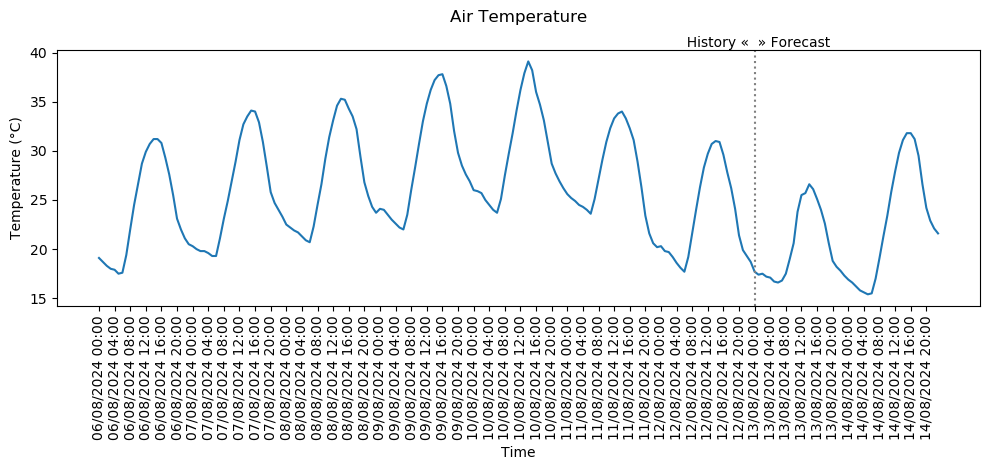

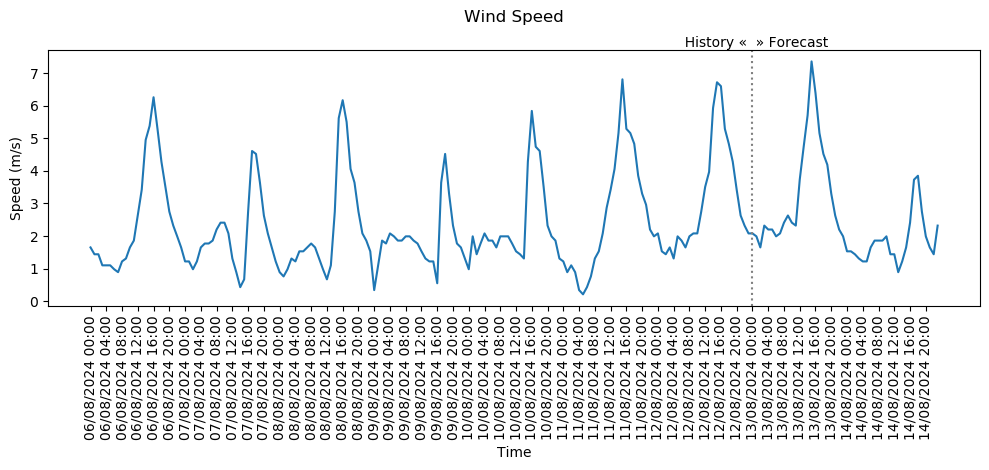

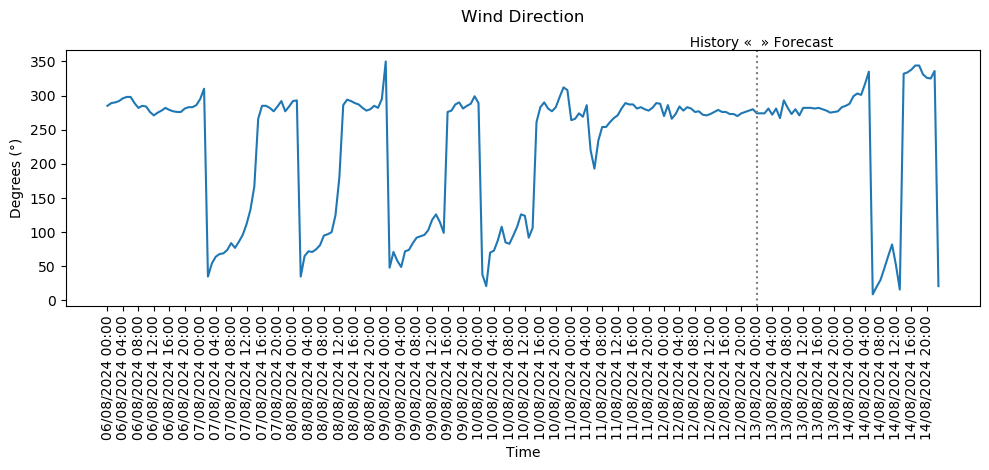

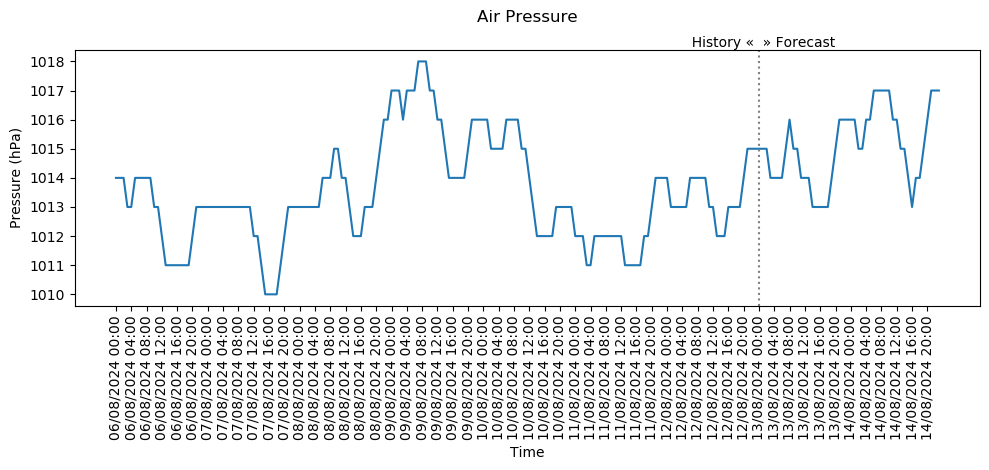

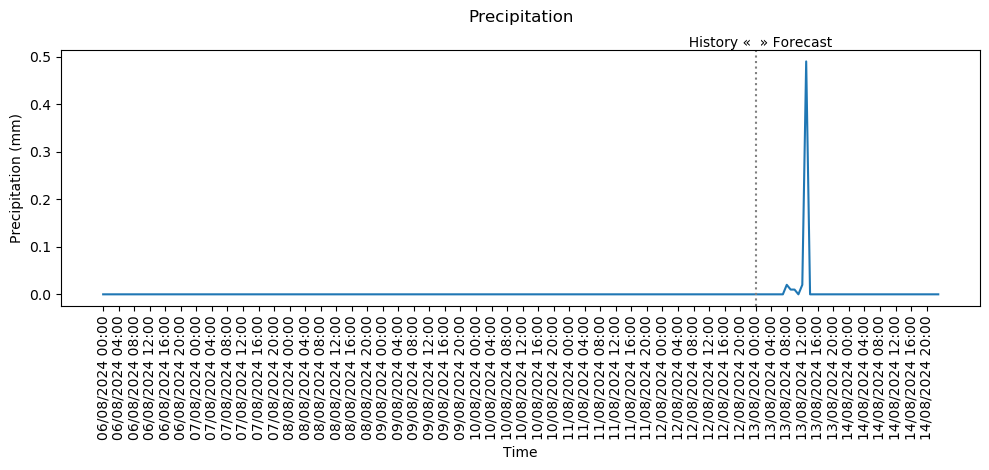

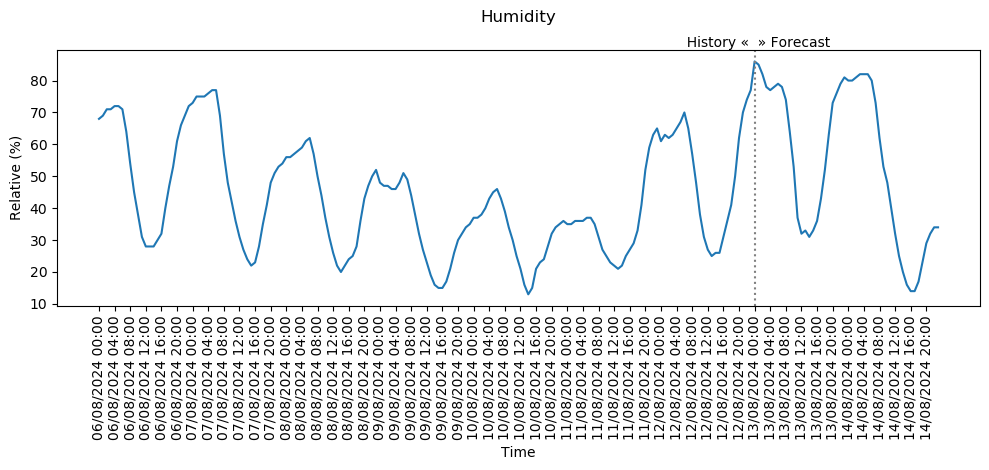

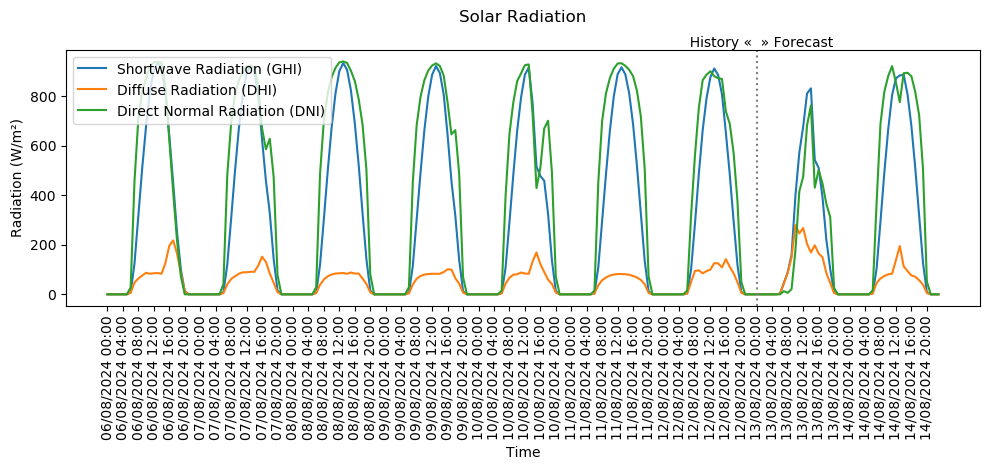

In [6]:
# Join history and forecast data
df_meteo = pd.concat([df_history, df_forecast], axis=0)

# Store the data on local csv file
df_meteo.index.name = 'datetime'
df_meteo.to_csv((f"output_data/meteo_full.csv"))

# Translate collumns to name and unit
def variable_translation(column):
    if (column == "temp_c"): param, unit = "Air Temperature", "Temperature (°C)"
    if (column == "wind_ms"): param, unit = "Wind Speed", "Speed (m/s)"
    if (column == "wind_degree"): param, unit = "Wind Direction", "Degrees (°)"
    if (column == "pressure_mb"): param, unit = "Air Pressure", "Pressure (hPa)"
    if (column == "humidity"): param, unit = "Humidity", "Relative (%)"
    if (column == "chance_of_rain"): param, unit = "Chance of Rain", "Probability (%)"
    if (column == "precip_mm"): param, unit = "Precipitation", "Precipitation (mm)"
    if (column == "shortwave_radiation_ghi"): param, unit = "Shortwave Radiation (GHI)", "Radiation (W/m²)"
    if (column == "diffuse_radiation_dhi"): param, unit = "Diffuse Radiation (DHI)", "Radiation (W/m²)"
    if (column == "direct_normal_irradiance_dni"): param, unit = "Direct Normal Radiation (DNI)", "Radiation (W/m²)"
    return param, unit
    
# Plot Style Function
def applyPlotStyle(column):
    param, unit = variable_translation(column)
    plt.title(f"{param}", pad=20)
    plt.xlabel('Time')
    plt.ylabel(unit)
    plt.xticks(rotation=90)
    plt.xticks(range(0, len(df_meteo), 4))
    plt.tight_layout()
    x_pos = len(df_meteo)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_meteo)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot the variables
for column in df_meteo.columns:
    if column not in ["shortwave_radiation_ghi", "diffuse_radiation_dhi", "direct_normal_irradiance_dni"]:
        plt.figure().set_figwidth(10)
        plt.plot(df_meteo.index.to_numpy(), df_meteo[column].to_numpy())
        applyPlotStyle(column)
        plt.savefig(f"output_graphs/meteo_{column}.png")

plt.figure().set_figwidth(10)
for column in df_meteo.columns:
    if column in ["shortwave_radiation_ghi", "diffuse_radiation_dhi", "direct_normal_irradiance_dni"]:
        param, _ = variable_translation(column) 
        plt.plot(df_meteo.index.to_numpy(), df_meteo[column].to_numpy(), label=param)
        plt.legend(loc="upper left")
applyPlotStyle(column)
plt.title(f"Solar Radiation", pad=20)
plt.savefig(f"output_graphs/meteo_solar_radiation.png")

***
# Gathering and processing of daily data for the past 30 days regarding estimated evapotranspiration ET<sub>0</sub>
### Data Source: IPMA
***

In [7]:
# URL of the ET0 CSV file
url = 'https://api.ipma.pt/open-data/observation/climate/evapotranspiration/viseu/et0-1819-tabuaco.csv'

# Fetch the CSV file
response = requests.get(url)
    
# Check if the request was successful
if response.status_code == 200:
    # Print information
    print(f"[{datetime.now()}] API evapotranspiration request successfully fetched.")
    
    # Read the CSV data into a DataFrame
    df = pd.read_csv(url)

    # Remove all columns except 'date' and 'mean'
    df_ipma_et0 = df[['date', 'mean']]

    # Keep the last 30 days
    df_ipma_et0 = df_ipma_et0[-30:]
    
    # Set the 'date' column as the index
    df_ipma_et0.set_index('date', inplace=True)
        
    # Convert index to datetime in UTC
    df_ipma_et0.index = pd.to_datetime(df_ipma_et0.index, utc=True)
    
    # Sort DataFrame by index (timestamp)
    df_ipma_et0.sort_index(inplace=True)

    # Change date format to day-month-year
    df_ipma_et0.index = df_ipma_et0.index.strftime('%d/%m/%Y')
    
    # Rename the 'mean' column to the data type
    df_ipma_et0 = df_ipma_et0.rename(columns={'mean': 'et0'})

else:
    print(f"Failed to retrieve data: {response.status_code}")

# Store the data on local csv file
df_ipma_et0.index.name = 'date'
df_ipma_et0.to_csv((f"output_data/meteo_ipma_et0.csv"))

# Print processed DataFrame (debug)
# print(df_ipma_et0)

# Print information
print(f"[{datetime.now()}] Data has been successfully processed.")

[2024-08-13 19:52:03.622016] API evapotranspiration request successfully fetched.
[2024-08-13 19:52:03.679006] Data has been successfully processed.


## Processed Data Analysis

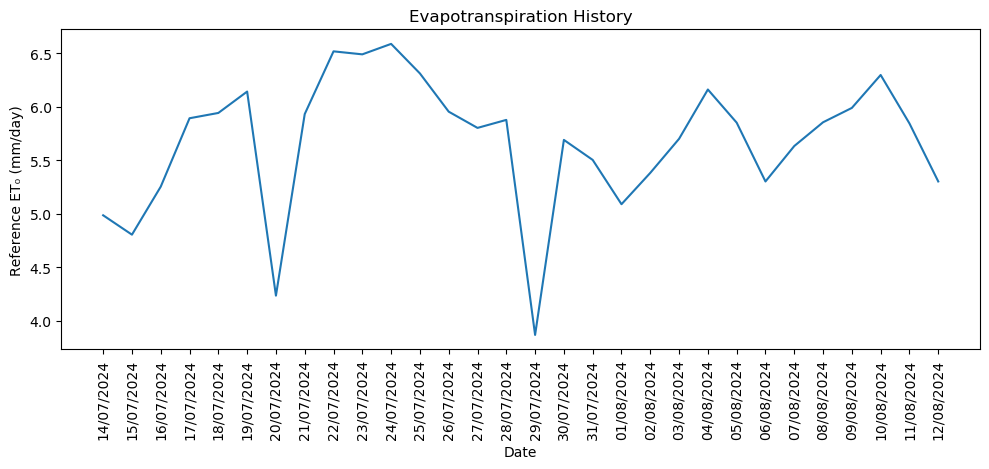

In [8]:
# Plot evapotranspiration history variable
plt.figure().set_figwidth(10)
plt.plot(df_ipma_et0.index.to_numpy(), df_ipma_et0['et0'].to_numpy())
plt.title(f'Evapotranspiration History')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Reference ET₀ (mm/day)')
plt.tight_layout()
plt.savefig(f"output_graphs/meteo_ipma_et0.png")

***
# Estimation of hourly photovoltaic energy production
### Method 1: simplified conversion to eletrical energy
***

In [9]:
# Define constants and parameters
A_panel = 1.92  # Area of PV panels in square meters (Canadian_Solar_CS6X_300M_2013 with 300Wp)
eta_stc = 0.156  # Standard Test Condition efficiency
gamma = -0.0045  # Temperature coefficient
NOCT = 45  # Nominal Operating Cell Temperature in °C
combined_losses = 0.1  # Combined losses factor

# Function to calculate hourly energy production
def calculate_pv_energy_simple(row):
    # For simplified calculations, GHI can be used as the irradiance
    H = row['shortwave_radiation_ghi'] # Unit W/m²
    T_amb = row['temp_c']
    T_c = T_amb + ((NOCT - 20) / 800) * H
    eta_temp = eta_stc * (1 + gamma * (T_c - 25))
    energy_hourly = H * A_panel * eta_temp * (1 - combined_losses)
    return NUMBER_OF_PANELS * energy_hourly / 1000 # Unit kWh

# Print information
print(f"[{datetime.now()}] Estimating hourly photovoltaic energy production using history and forecast weather.")

# Calculate photovoltaic hourly energy production using history and forecast weather
df_pv = df_meteo.apply(calculate_pv_energy_simple, axis=1)

# Store the data on local csv file
df_pv.index.name = 'datetime'
df_pv.name = 'pv_energy'
df_pv.to_csv((f"output_data/estimated_pv_energy_1.csv"))

# Print the processed DataFrames (debug)
# print(df_pv)

# Print information
print(f"[{datetime.now()}] Hourly photovoltaic energy production has been successfully estimated, with Method 1.")

[2024-08-13 19:52:03.864800] Estimating hourly photovoltaic energy production using history and forecast weather.
[2024-08-13 19:52:03.867401] Hourly photovoltaic energy production has been successfully estimated, with Method 1.


## Estimated Data Analysis

Total Estimated Photovoltaic Energy Production for 06/08/2024: 7.11 kWh
Total Estimated Photovoltaic Energy Production for 07/08/2024: 7.08 kWh
Total Estimated Photovoltaic Energy Production for 08/08/2024: 7.17 kWh
Total Estimated Photovoltaic Energy Production for 09/08/2024: 6.90 kWh
Total Estimated Photovoltaic Energy Production for 10/08/2024: 6.37 kWh
Total Estimated Photovoltaic Energy Production for 11/08/2024: 7.07 kWh
Total Estimated Photovoltaic Energy Production for 12/08/2024: 7.04 kWh
Total Estimated Photovoltaic Energy Production for 13/08/2024: 5.33 kWh
Total Estimated Photovoltaic Energy Production for 14/08/2024: 7.14 kWh


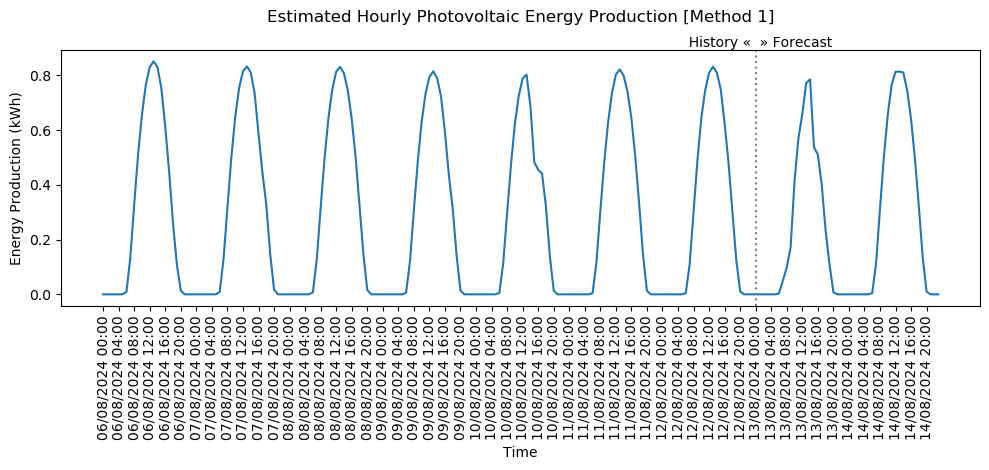

In [10]:
# Plot Style Function
def applyPlotStyle():
    plt.title(f"Estimated Hourly Photovoltaic Energy Production [Method 1]", pad=20)
    plt.xlabel('Time')
    plt.ylabel('Energy Production (kWh)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(df_pv)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_pv)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated hourly photovoltaic energy production  
plt.figure().set_figwidth(10)
plt.plot(df_pv)
plt.xticks(range(0, len(df_pv), 4))
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_pv_energy_1.png")

# Resample the data to daily frequency and sum the values per day
df_pv_sum = df_pv.copy()
df_pv_sum.index = pd.to_datetime(df_pv_sum.index, format='%d/%m/%Y %H:%M')
df_pv_sum = df_pv_sum.resample('D').sum()

# Display the results
for index, value in df_pv_sum.items():
    print(f"Total Estimated Photovoltaic Energy Production for {index.strftime('%d/%m/%Y')}: {value:.2f} kWh")

***
# Estimation of hourly photovoltaic energy production
### Method 2: using Python PvLib
***

In [11]:
def calculate_pv_energy_lib(df):
    # Latitude and longitude for the photovoltaic site: Valença do Douro, Portugal
    latitude = 41.173156
    longitude = -7.548373
    altitude = 250  # in meters
    timezone = 'Europe/Lisbon'
    
    # Retrieve data from df_24h DataFrame
    data = {
        'temp_air': df['temp_c'],  # in °C
        'relative_humidity': df['humidity'],  # in percentage
        'wind_speed': df['wind_ms'],  # in m/s
        'pressure': df['pressure_mb'],  # in mbar = hPa
        'ghi': df['shortwave_radiation_ghi'],  # in W/m2
        'dhi': df['diffuse_radiation_dhi'],  # in W/m2
        'dni': df['direct_normal_irradiance_dni']  # in W/m2
    }
    
    # Construct weather Dataframe to use pvlib
    weather = pd.DataFrame(data)
    
    # Fomart index to use pvlib
    start_datetime = datetime.strptime(weather.index[0], '%d/%m/%Y %H:%M')
    weather.index = pd.date_range(start=start_datetime, periods=len(weather), freq='H', tz=timezone)
    
    # Calculate solar position
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=weather["pressure"],
    )
    
    # Long-wave infrared radiation placeholder
    weather['IR(h)'] = 350  # W/m²
    
    # Define system specifications
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    module = sandia_modules['Canadian_Solar_CS6X_300M__2013_'] # 300Wp Module
    inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
    system = {'module': module, 'inverter': inverter, 'surface_azimuth': 180, 'surface_tilt': latitude}
    
    # Calculate energy yield
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )

    # Calculate DC and AC energy
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter) * NUMBER_OF_PANELS / 1000 # Unit kWh
    
    # Replace NaN values with 0
    dc.fillna(0, inplace=True)
    ac.fillna(0, inplace=True)
    
    # Convert index back to normal
    ac.index = ac.index.strftime('%d/%m/%Y %H:%S')

    # Rename the header of AC dataframe
    ac.index.name = 'datetime'
    ac.name = 'pv_energy'
    
    return ac

# Print information
print(f"[{datetime.now()}] Estimating hourly photovoltaic energy production using history and forecast weather.")

# Calculate photovoltaic hourly energy production using history and forecast weather
df_pv = calculate_pv_energy_lib(df_meteo)

# Store the data on local csv file
df_pv.to_csv((f"output_data/estimated_pv_energy_2.csv"))

# Print the processed DataFrames (debug)
# print(df_pv)

# Print information
print(f"[{datetime.now()}] Hourly photovoltaic energy production has been successfully estimated, with Method 2.")

[2024-08-13 19:52:04.331978] Estimating hourly photovoltaic energy production using history and forecast weather.
[2024-08-13 19:52:04.385460] Hourly photovoltaic energy production has been successfully estimated, with Method 2.


## Estimated Data Analysis

Total Estimated Photovoltaic Energy Production for 06/08/2024: 6.72 kWh
Total Estimated Photovoltaic Energy Production for 07/08/2024: 6.59 kWh
Total Estimated Photovoltaic Energy Production for 08/08/2024: 6.80 kWh
Total Estimated Photovoltaic Energy Production for 09/08/2024: 6.50 kWh
Total Estimated Photovoltaic Energy Production for 10/08/2024: 5.99 kWh
Total Estimated Photovoltaic Energy Production for 11/08/2024: 6.89 kWh
Total Estimated Photovoltaic Energy Production for 12/08/2024: 6.94 kWh
Total Estimated Photovoltaic Energy Production for 13/08/2024: 5.48 kWh
Total Estimated Photovoltaic Energy Production for 14/08/2024: 6.93 kWh


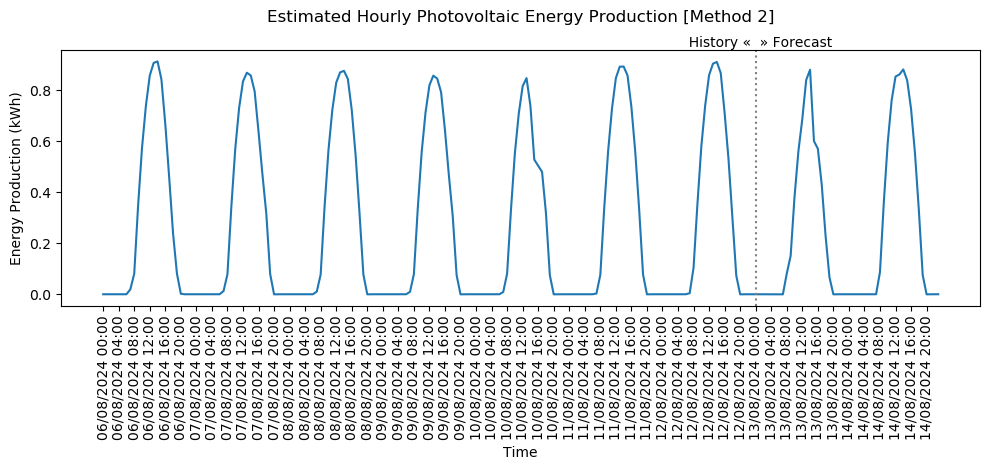

In [12]:
# Plot Style Function
def applyPlotStyle():
    plt.title(f"Estimated Hourly Photovoltaic Energy Production [Method 2]", pad=20)
    plt.xlabel('Time')
    plt.ylabel('Energy Production (kWh)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(df_pv)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_pv)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated hourly photovoltaic energy production  
plt.figure().set_figwidth(10)
plt.plot(df_pv)
plt.xticks(range(0, len(df_pv), 4))
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_pv_energy_2.png")

# Resample the data to daily frequency and sum the values per day
df_pv_sum = df_pv.copy()
df_pv_sum.index = pd.to_datetime(df_pv_sum.index, format='%d/%m/%Y %H:%M')
df_pv_sum = df_pv_sum.resample('D').sum()

# Display the results
for index, value in df_pv_sum.items():
    print(f"Total Estimated Photovoltaic Energy Production for {index.strftime('%d/%m/%Y')}: {value:.2f} kWh")

***
# Estimation of hourly wind energy production
### Method 1: simplified conversion to eletrical energy
***

In [13]:
# Define constants and parameters for wind speed adjustment
z_ref = 10  # Reference height (measurement height) in meters
z = 25  # Rotor height in meters
z0 = 0.25  # Surface roughness length in meters (estimated surface roughness of vineyards)

# Define constants and parameters for the wind turbine (RyseEnergy E-5 HAWT)
rho = 1.225  # Air density in kg/m³
Cp = 0.40  # Power coefficient
radius = 2.15  # Radius of the wind turbine in meters
A = np.pi * radius**2  # Rotor swept area in m²
rated_power = 4000  # Rated power of the turbine in watts
rated_speed = 11  # Rated wind speed in m/s
cut_in_speed = 2  # Cut-in wind speed in m/s
cut_out_speed = 60  # Cut-out wind speed in m/s
availability = 0.9  # Turbine availability factor

# Function to calculate eolic hourly energy production
def calculate_eolic_energy_simple(row):
    # Calculate wind speed ajusted at rotor height using the logarithmic wind profile
    wind_speed_ref = row['wind_ms']
    wind_speed_rotor = wind_speed_ref * np.log(z / z0) / np.log(z_ref / z0)
    
    if wind_speed_rotor < cut_in_speed or wind_speed_rotor > cut_out_speed:
        # Power is null in below cut-in and above cut-out speeds
        power_output = 0
    elif wind_speed_rotor <= rated_speed:
        # Calculate using power equation
        power_output = 0.5 * rho * A * (wind_speed_rotor**3) * Cp
    else:
        # Power is capped at rated power
        power_output = rated_power
        
    # Apply availability factor
    energy_hourly = power_output * availability
    
    return NUMBER_OF_TURBINES * energy_hourly / 1000 # Unit kWh

# Print information
print(f"[{datetime.now()}] Estimating hourly wind energy production using history and forecast weather.")

# Calculate eolic hourly energy production using history and forecast weather
df_eolic = df_meteo.apply(calculate_eolic_energy_simple, axis=1)

# Store the data on local csv file
df_eolic.index.name = 'datetime'
df_eolic.name = 'eolic_energy'
df_eolic.to_csv((f"output_data/estimated_wind_energy_1.csv"))

# Print the processed DataFrame (debug)
# print(df_eolic)

# Print information
print(f"[{datetime.now()}] Hourly wind energy production has been successfully estimated, with Method 1.")

[2024-08-13 19:52:04.849807] Estimating hourly wind energy production using history and forecast weather.
[2024-08-13 19:52:04.852227] Hourly wind energy production has been successfully estimated, with Method 1.


## Estimated Data Analysis

Total Estimated Wind Energy Production for 06/08/2024: 5.68 kWh
Total Estimated Wind Energy Production for 07/08/2024: 2.25 kWh
Total Estimated Wind Energy Production for 08/08/2024: 4.77 kWh
Total Estimated Wind Energy Production for 09/08/2024: 1.67 kWh
Total Estimated Wind Energy Production for 10/08/2024: 3.87 kWh
Total Estimated Wind Energy Production for 11/08/2024: 7.03 kWh
Total Estimated Wind Energy Production for 12/08/2024: 8.74 kWh
Total Estimated Wind Energy Production for 13/08/2024: 9.41 kWh
Total Estimated Wind Energy Production for 14/08/2024: 1.28 kWh


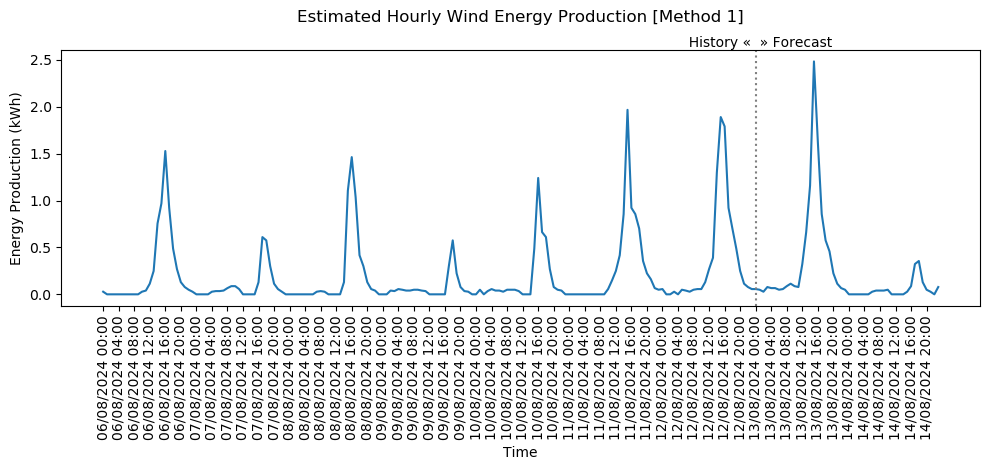

In [14]:
# Plot Style Function
def applyPlotStyle():
    plt.title(f"Estimated Hourly Wind Energy Production [Method 1]", pad=20)
    plt.xlabel('Time')
    plt.ylabel('Energy Production (kWh)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(df_eolic)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_eolic)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated hourly photovoltaic energy production  
plt.figure().set_figwidth(10)
plt.plot(df_eolic)
plt.xticks(range(0, len(df_eolic), 4))
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_wind_energy_1.png")

# Resample the data to daily frequency and sum the values per day
df_eolic_sum = df_eolic.copy()
df_eolic_sum.index = pd.to_datetime(df_eolic_sum.index, format='%d/%m/%Y %H:%M')
df_eolic_sum = df_eolic_sum.resample('D').sum()

# Display the results
for index, value in df_eolic_sum.items():
    print(f"Total Estimated Wind Energy Production for {index.strftime('%d/%m/%Y')}: {value:.2f} kWh")

***
# Estimation of hourly wind energy production
### Method 2: considering power curve
***

In [15]:
# Define constants and parameters for wind speed adjustment
z_ref = 10  # Reference height (measurement height) in meters
z = 30  # Rotor height in meters
z0 = 0.25  # Surface roughness length in meters (estimated surface roughness of vineyards)
kappa = 0.4  # von Kármán constant

# Define constants and parameters for the wind turbine (RyseEnergy E-5 HAWT)
rated_power = 4000  # Rated power of the turbine in W
rated_speed = 11  # Rated wind speed in m/s
cut_in_speed = 2  # Cut-in wind speed in m/s
cut_out_speed = 60  # Cut-out wind speed in m/s
availability = 0.9  # Turbine availability factor

# Define the power curve (RyseEnergy E-5 HAWT) m/s : W
power_curve = {2:10, 3:50, 4:260, 5:456, 6:900, 7:1400, 8:2000, 9:2800, 10:3500, 11:4000}

# Function to calculate hourly energy production
def calculate_eolic_energy_pc(row):
    # Calculate wind speed ajusted at rotor height using the logarithmic wind profile
    wind_speed_ref = row['wind_ms']
    wind_speed_rotor = wind_speed_ref * np.log(z / z0) / np.log(z_ref / z0)
    
    if wind_speed_rotor < cut_in_speed or wind_speed_rotor > cut_out_speed:
        # Power is null in below cut-in and above cut-out speeds
        power_output = 0
    elif wind_speed_rotor <= rated_speed:
        # Calculate using linear interpolation on power curve
        interp_power_curve = interp1d(list(power_curve.keys()), list(power_curve.values()))
        power_output = interp_power_curve(wind_speed_rotor)
    else:
        # Power is capped at rated power
        power_output = rated_power  

    # Apply availability factor
    energy_hourly = power_output * availability
    
    return NUMBER_OF_TURBINES * energy_hourly / 1000 # Unit kWh
    
# Print information
print(f"[{datetime.now()}] Estimating hourly wind energy production using history and forecast weather.")

# Calculate eolic hourly energy production using history and forecast weather
df_eolic = df_meteo.apply(calculate_eolic_energy_pc, axis=1)

# Store the data on local csv file
df_eolic.index.name = 'datetime'
df_eolic.name = 'eolic_energy'
df_eolic.to_csv((f"output_data/estimated_wind_energy_2.csv"))

# Print the processed DataFrame (debug)
# print(df_eolic)

# Print information
print(f"[{datetime.now()}] Hourly wind energy production has been successfully estimated, with Method 2.")

[2024-08-13 19:52:05.315685] Estimating hourly wind energy production using history and forecast weather.
[2024-08-13 19:52:05.327475] Hourly wind energy production has been successfully estimated, with Method 2.


## Estimated Data Analysis

Total Estimated Wind Energy Production for 06/08/2024: 7.04 kWh
Total Estimated Wind Energy Production for 07/08/2024: 2.53 kWh
Total Estimated Wind Energy Production for 08/08/2024: 5.85 kWh
Total Estimated Wind Energy Production for 09/08/2024: 1.74 kWh
Total Estimated Wind Energy Production for 10/08/2024: 4.57 kWh
Total Estimated Wind Energy Production for 11/08/2024: 8.79 kWh
Total Estimated Wind Energy Production for 12/08/2024: 10.61 kWh
Total Estimated Wind Energy Production for 13/08/2024: 11.14 kWh
Total Estimated Wind Energy Production for 14/08/2024: 1.23 kWh


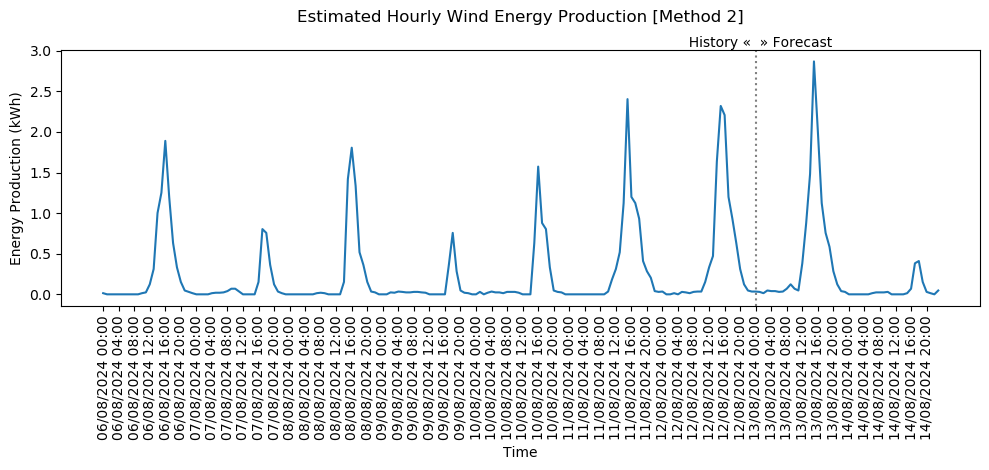

In [16]:
# Plot Style Function
def applyPlotStyle():
    plt.title(f"Estimated Hourly Wind Energy Production [Method 2]", pad=20)
    plt.xlabel('Time')
    plt.ylabel('Energy Production (kWh)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(df_eolic)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_eolic)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated hourly photovoltaic energy production  
plt.figure().set_figwidth(10)
plt.plot(df_eolic)
plt.xticks(range(0, len(df_eolic), 4))
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_wind_energy_2.png")

# Resample the data to daily frequency and sum the values per day
df_eolic_sum = df_eolic.copy()
df_eolic_sum.index = pd.to_datetime(df_eolic_sum.index, format='%d/%m/%Y %H:%M')
df_eolic_sum = df_eolic_sum.resample('D').sum()

# Display the results
for index, value in df_eolic_sum.items():
    print(f"Total Estimated Wind Energy Production for {index.strftime('%d/%m/%Y')}: {value:.2f} kWh")

***
# Estimation of daily reference evapotranspiration ET<sub>0</sub> and total precipitation (mm/day)
### Method: FAO56 Penman-Monteith equation
***

In [17]:
# Units: (ºC, %, m/s at 2m, MJ/m2, kPa, 1-365, rad, m)
def estimate_daily_et0_formula(temp, humidity, wind_speed, solar_radiation, pressure, day_of_year, latitude, altitude):
    # Define constants for below calculations
    albedo = 0.23 # default value
    stefan_boltzmann_constant = 0.000000004903
    solar_constant = 0.0820

    # Prepare values for daily ET0 calculation
    T_max = max(temp)
    T_min = min(temp)
    T_mean = (T_max+T_min)/2
    RH_max = max(humidity)
    RH_min = min(humidity)
    ws = sum(wind_speed) / len(wind_speed)
    atm_mean = sum(pressure) / len(pressure)
    sol_rad = sum(solar_radiation)
    
    # Calculate svp: saturation vapour pressure derived from air temperature
    svp_tmin = 0.6108 * math.exp((17.27 * T_min) / (T_min + 237.3))
    svp_tmax = 0.6108 * math.exp((17.27 * T_max) / (T_max + 237.3))
    svp = (svp_tmin + svp_tmax) / 2

    # Calculate avp: actual vapour pressure derived from relative humidity
    aux1 = svp_tmin * (RH_max / 100.0)
    aux2 = svp_tmax * (RH_min / 100.0)
    avp = (aux1 + aux2) / 2.0 
    
    # Calculate delta_svp: slope of saturation vapour pressure curve
    aux = 4098 * (0.6108 * math.exp((17.27 * T_mean) / (T_mean + 237.3)))
    delta_svp = aux / math.pow((T_mean + 237.3), 2)

    # Calculate psy: psychrometric constant
    psy = 0.000665 * atm_mean
    
    # Calculate sol_dec: solar declination from day of the year
    sol_dec = 0.409 * math.sin(((2.0 * math.pi / 365.0) * day_of_year - 1.39))
    
    # Calculate sha: sunset hour angle from solar declination and latitude
    cos_sha = -math.tan(latitude) * math.tan(sol_dec)
    sha = math.acos(min(max(cos_sha, -1.0), 1.0))

    # Calculate ird: inverse relative distance between earth and sun from day of the year
    ird = 1 + (0.033 * math.cos((2.0 * math.pi / 365.0) * day_of_year))
    
    # Calculate et_rad: daily extraterrestrial radiation
    aux1 = (24.0 * 60.0) / math.pi
    aux2 = sha * math.sin(latitude) * math.sin(sol_dec)
    aux3 = math.cos(latitude) * math.cos(sol_dec) * math.sin(sha)
    et_rad = aux1 * solar_constant * ird * (aux2 + aux3)
    
    # Estimate clear sky radiation from altitude and extraterrestrial radiation
    cs_rad = (0.00002 * altitude + 0.75) * et_rad

    # Net outgoing longwave radiation
    aux1 = (stefan_boltzmann_constant * ((math.pow(T_max, 4) + math.pow(T_min, 4)) / 2))
    aux2 = (0.34 - (0.14 * math.sqrt(avp)))
    aux3 = 1.35 * (sol_rad / cs_rad) - 0.35
    no_lw_rad = aux1 * aux2 * aux3

    # Net incoming shortwave radiation
    ni_sw_rad = (1 - albedo) * sol_rad 

    # Calculate net_rad: net radiation
    net_rad = ni_sw_rad - no_lw_rad
    
    # Soil Heat Flux: can be considered null for a daily estimation
    shf = 0
    
    # Calculate ET0
    aux1 = (0.408 * (net_rad - shf) * delta_svp /
          (delta_svp + (psy * (1 + 0.34 * ws)))) * 0.95
    aux2 = (900 * ws / T_mean * (svp - avp) * psy /
          (delta_svp + (psy * (1 + 0.34 * ws)))) * 0.05
    
    daily_et0 = aux1+aux2
    
    return daily_et0*0.90

In [18]:
# Function to estimate daily reference evapotranspiration and total precipitation
def estimate_daily_et0(df):
    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index, format="%d/%m/%Y %H:%M")
    
    # Group by the date part of the datetime index
    grouped = df.groupby(df.index.date)
    
    # Create a dictionary to hold each day's dataframe
    df_days = {date: group for date, group in grouped}
    df_days = {date.strftime("%d/%m/%Y"): group for date, group in grouped}
    
    # Iterate through the dictionary and format the index of each DataFrame
    for date, df_day in df_days.items():
        df_day.index = df_day.index.strftime("%d/%m/%Y %H:%M")
    
    # Initialize empty list to hold DataFrame for forecast evapotranspiration
    dfs_et0 = []
    
    for i in range(len(df_days.keys())):    
        # Loop through each day in forecast DataFrame
        specific_date = list(df_days.keys())[i]
        df_day = df_days[specific_date]
    
        # Print information
        print(f"[{datetime.now()}] Estimating daily reference evapotranspiration and total precipitation for {df_day.index[0][:-6]}.")
        
        # Retrieve data from df_forecast_day DataFrame    
        temp = df_day['temp_c'] # in °C
        humidity = df_day['humidity'] # in %
        wind_speed_ref = df_day['wind_ms'] # in m/s at 10 meters
        solar_radiation_wm2 = df_day['shortwave_radiation_ghi'] # in Wh/m2
        pressure_hpa = df_day['pressure_mb'] # in mbar = hPa
        precip_mm = df_day['precip_mm'] # in mm
        day_of_year = pd.Series(pd.to_datetime(df_day.index, format='%d/%m/%Y %H:%M').dayofyear).mode()[0] # converted to 1~365
    
        # Define constants and parameters for wind speed adjustment
        z_ref = 10  # Reference height (measurement height) in meters
        z = 2  # FAO-56 standard height in meters
        z0 = 0.25  # Surface roughness length in meters (estimated surface roughness of vineyards)
    
        # Calculate wind speed ajusted at FAO-56 standard height using the logarithmic wind profile
        wind_speed = wind_speed_ref * np.log(z / z0) / np.log(z_ref / z0)
    
        # Convert short_rad from Wh/m2 to MJ/m2
        solar_radiation = solar_radiation_wm2 * 3600 / 1e6
        
        # Convert pressure from hPa to kPa
        pressure = pressure_hpa * 0.1
        df_day['pressure_mb']
        # Convert latitude to radians
        latitude = 41.173156 * (math.pi / 180.0)
    
        # Altitude in meters
        altitude = 250
    
        # Estimate daily reference evapotranspiration
        et0 = estimate_daily_et0_formula(temp, humidity, wind_speed, solar_radiation, pressure, day_of_year, latitude, altitude)

        # Estimate total precipitation
        precip = sum(precip_mm)
        
        # Create DataFrame for evapotranspiration and total precipitation data, including the date
        df_et0 = pd.DataFrame({'total_precip': [precip], 'estimated_et0': [et0]}, index=[specific_date])
            
        # Append the DataFrames to the respective lists
        dfs_et0.append(df_et0)
    
    # Concatenate all the DataFrames into one
    df_et0 = pd.concat(dfs_et0)

    return df_et0

# Estimate reference evapotranspiration using history and forecast weather
df_et0 = estimate_daily_et0(df_meteo.copy())

# Store the data on local csv file
df_et0.index.name = 'date'
df_et0.to_csv((f"output_data/estimated_et0.csv"))

# Print the processed DataFrame (debug)
# print(df_et0)

# Print information
print(f"[{datetime.now()}] Daily reference evapotranspiration have been successfully estimated.")

[2024-08-13 19:52:05.808173] Estimating daily reference evapotranspiration and total precipitation for 06/08/2024.
[2024-08-13 19:52:05.809631] Estimating daily reference evapotranspiration and total precipitation for 07/08/2024.
[2024-08-13 19:52:05.810852] Estimating daily reference evapotranspiration and total precipitation for 08/08/2024.
[2024-08-13 19:52:05.811808] Estimating daily reference evapotranspiration and total precipitation for 09/08/2024.
[2024-08-13 19:52:05.812637] Estimating daily reference evapotranspiration and total precipitation for 10/08/2024.
[2024-08-13 19:52:05.813562] Estimating daily reference evapotranspiration and total precipitation for 11/08/2024.
[2024-08-13 19:52:05.814372] Estimating daily reference evapotranspiration and total precipitation for 12/08/2024.
[2024-08-13 19:52:05.815185] Estimating daily reference evapotranspiration and total precipitation for 13/08/2024.
[2024-08-13 19:52:05.816020] Estimating daily reference evapotranspiration and t

## Estimated Data Analysis

Estimated Reference Evapotranspiration and Total Precipitation for 06/08/2024: 5.75 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 07/08/2024: 5.89 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 08/08/2024: 6.23 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 09/08/2024: 6.22 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 10/08/2024: 6.04 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 11/08/2024: 6.12 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 12/08/2024: 5.78 / 0.00 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 13/08/2024: 4.22 / 0.55 (mm/day)
Estimated Reference Evapotranspiration and Total Precipitation for 14/08/2024: 5.73 / 0.00 (mm/day)


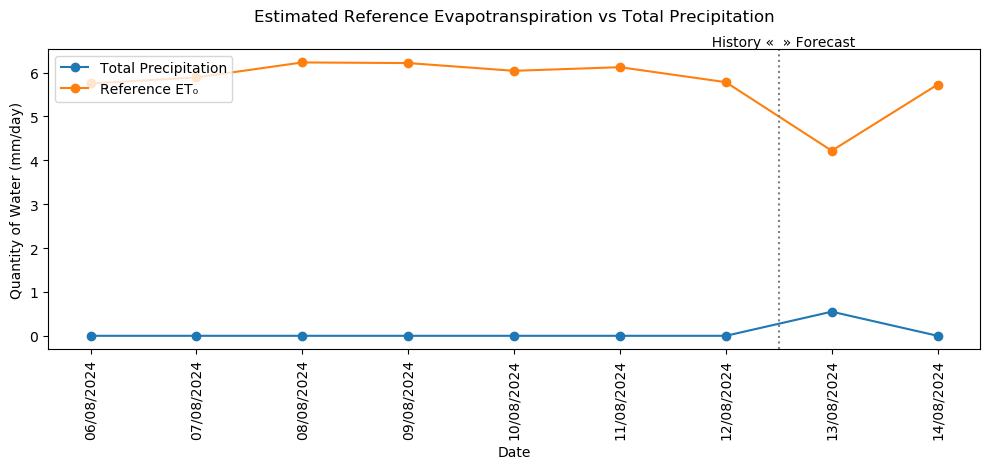

In [19]:
# Translate collumns to name
def et0_translation(column):
    if (column == "estimated_et0"): param = "Reference ET₀"
    if (column == "total_precip"): param = "Total Precipitation"
    return param

# Plot Style Function
def applyPlotStyle():
    plt.title(f"Estimated Reference Evapotranspiration vs Total Precipitation", pad=20)
    plt.xlabel('Date')
    plt.ylabel('Quantity of Water (mm/day)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(df_et0)-2.5
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_et0)-2.5, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated reference evapotranspiration vs precipitation history
plt.figure().set_figwidth(10)
for column in df_et0.columns:
    param = et0_translation(column)
    plt.plot(df_et0.index.to_numpy(), df_et0[column].to_numpy(), '-o', label=param)
plt.legend(loc="upper left")
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_et0.png")

# Display the results
for index, row in df_et0.iterrows():
    print(f"Estimated Reference Evapotranspiration and Total Precipitation for {index}: {row['estimated_et0']:.2f} / {row['total_precip']:.2f} (mm/day)")

***
# Estimation of hourly soil moisture
### Method: simulated through EnsembleAPI
***

In [20]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
	"latitude": 41.173156,
	"longitude": -7.548373,
	"hourly": ["soil_moisture_0_to_10cm", "soil_moisture_10_to_40cm", "soil_moisture_40_to_100cm"],
    "timezone": "GMT",
	"past_days": 7,
	"forecast_days": 2,
	"models": "gfs_seamless"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

# Print information
print(f"[{datetime.now()}] EnsembleAPI history request for the past 7 days, current day and following day successfully fetched.")

# Process hourly data
hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_soil_moisture_0_to_10cm = filter(lambda x: x.Variable() == Variable.soil_moisture and x.Depth() == 0 and x.DepthTo() == 10, hourly_variables)
hourly_soil_moisture_10_to_40cm = filter(lambda x: x.Variable() == Variable.soil_moisture and x.Depth() == 10 and x.DepthTo() == 40, hourly_variables)
hourly_soil_moisture_40_to_100cm = filter(lambda x: x.Variable() == Variable.soil_moisture and x.Depth() == 40 and x.DepthTo() == 100, hourly_variables)

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

# Process all members
for variable in hourly_soil_moisture_0_to_10cm:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"soil_moisture_0_to_10cm"] = variable.ValuesAsNumpy()
for variable in hourly_soil_moisture_10_to_40cm:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"soil_moisture_10_to_40cm"] = variable.ValuesAsNumpy()
for variable in hourly_soil_moisture_40_to_100cm:
	member = variable.EnsembleMember()
	if member == 0: hourly_data[f"soil_moisture_40_to_100cm"] = variable.ValuesAsNumpy()

# Create DataFrame
df_moisture = pd.DataFrame(data = hourly_data)

# Convert 'date' column to datetime object
df_moisture['date'] = pd.to_datetime(df_moisture['date'])

# Change date format to day-month-year hour:minute
df_moisture['time'] = df_moisture['date'].dt.strftime('%d/%m/%Y %H:%M')

# Set 'time' as the index
df_moisture.set_index('time', inplace=True)

# Drop the original 'date' column if not needed anymore
df_moisture.drop(columns=['date'], inplace=True)

# Store the data on local csv file
df_moisture.index.name = 'datetime'
df_moisture.to_csv((f"output_data/estimated_moisture.csv"))

# Print the processed DataFrame (debug)
# print(df_moisture)

# Print information
print(f"[{datetime.now()}] Data has been successfully processed.")

[2024-08-13 19:52:05.967744] EnsembleAPI history request for the past 7 days, current day and following day successfully fetched.
[2024-08-13 19:52:05.973105] Data has been successfully processed.


## Estimated Data Analysis

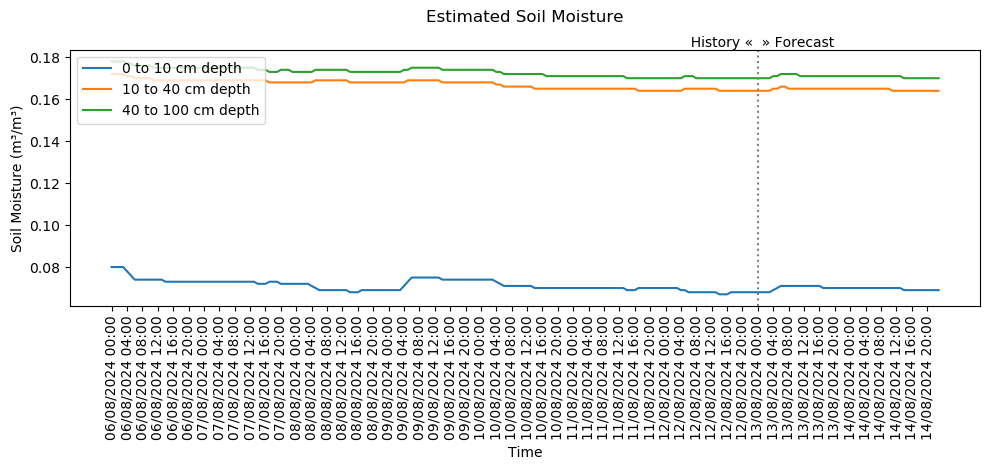

In [21]:
# Translate collumns to name
def moisture_translation(column):
    if (column == "soil_moisture_0_to_10cm"): param = "0 to 10 cm depth"
    if (column == "soil_moisture_10_to_40cm"): param = "10 to 40 cm depth"
    if (column == "soil_moisture_40_to_100cm"): param = "40 to 100 cm depth"
    return param

# Plot Style Function
def applyPlotStyle():
    plt.title(f"Estimated Soil Moisture", pad=20)
    plt.xlabel('Time')
    plt.ylabel('Soil Moisture (m³/m³)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    x_pos = len(df_moisture)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(df_moisture)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot estimated soil moisture
plt.figure().set_figwidth(10)
for column in df_moisture.columns:
    param = moisture_translation(column)
    plt.plot(df_moisture.index.to_numpy(), df_moisture[column].to_numpy(), label=param)
plt.xticks(range(0, len(df_moisture), 4))
plt.legend(loc="upper left")
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_moisture.png")

***
# Gathering and processing of OMIE energy price for the past 7 days, current day and following day
### Data Source: SPOT OMIE Daily Market
***

In [22]:
# Since the response time is high, data files are stored locally to optimize the process

# Base URL of the OMIE CSV files
base_url = 'https://www.omie.es/pt/file-download?parents%5B0%5D=marginalpdbcpt&filename=marginalpdbcpt_'

# Create the omie files folder if it doesn't exist
folder_name = 'omie'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Initialize an empty list to hold DataFrames
df_omie_list = []

# Loop through the past 7 days including today and tomorrow's information
for i in range(-1, 8):
    # Calculate the date for the current iteration
    date = datetime.now().date() - timedelta(days=i)
    
    # Format the date in the required format for the URL and filepath
    date_str = date.strftime('%Y%m%d')

    # Construct the URL
    url = base_url + date_str + '.1'
    
    # Construct the file path
    file_path = os.path.join(folder_name, f'marginalpdbcpt_{date_str}.csv')

    # Check if the file already exists in the folder
    if os.path.exists(file_path):
        # Print information 
        print(f"[{datetime.now()}] Local file found for day {date_str}. Respective data has been successfully fetched.")
    
    # If the file doesn't exist, download it
    else:
        # Print information 
        print(f"[{datetime.now()}] Local file not found for day {date_str}. Attempting to download.")
        
        # Parse the JSON response
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Print information
            print(f"[{datetime.now()}] File for day {date_str} downloaded. Respective data has been successfully fetched.")
            
            # Save the CSV file
            with open(file_path, 'w') as f:
                f.write(response.text)
        else:
            print(f"[{datetime.now()}] Failed to retrieve data for {date.strftime('%d/%m/%Y')}: {response.status_code}")
            continue

    # Read the CSV data into a DataFrame
    df = pd.read_csv(file_path, delimiter=';', header=None, skiprows=1)

    # Append the DataFrame to the list
    df_omie_list.append(df)

# Concatenate all DataFrames in the list
df_omie = pd.concat(df_omie_list)

# Drop the last row
df_omie.drop(df_omie.tail(1).index, inplace=True)

# Rename columns
df_omie.columns = ['year', 'month', 'day', 'hour', 'pt_price', 'es_price', 'comma']

# Concatenate year, month, day, and hour to form datetime column
df_omie['datetime'] = pd.to_datetime(df_omie[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H')

# Set datetime as index
df_omie.set_index('datetime', inplace=True)

# Sort the DataFrame by datetime indexfor the current date
df_omie = df_omie.sort_index()

# Drop unnecessary columns
df_omie.drop(['year', 'month', 'day', 'hour', 'comma', 'es_price'], axis=1, inplace=True)

# Convert price from EUR/MWh to EUR/kWh
df_omie['pt_price'] = df_omie['pt_price'] / 1000

# Convert Madrid time to Lisbon time
df_omie.index = df_omie.index.tz_localize('Europe/Madrid').tz_convert('Europe/Lisbon')

# Change date format to day-month-year
df_omie.index = df_omie.index.strftime('%d/%m/%Y %H:00')

# Print information
print(f"[{datetime.now()}] OMIE data has been successfully processed.")

# Print the Processed DataFrame (debug)
# print(df_omie)

# Store the data
df_omie.to_csv((f"output_data/estimated_energy_omie_price.csv"))

[2024-08-13 19:52:06.470544] Local file not found for day 20240814. Attempting to download.
[2024-08-13 19:52:11.015755] File for day 20240814 downloaded. Respective data has been successfully fetched.
[2024-08-13 19:52:11.018092] Local file not found for day 20240813. Attempting to download.
[2024-08-13 19:52:15.275363] File for day 20240813 downloaded. Respective data has been successfully fetched.
[2024-08-13 19:52:15.277551] Local file not found for day 20240812. Attempting to download.
[2024-08-13 19:52:19.757993] File for day 20240812 downloaded. Respective data has been successfully fetched.
[2024-08-13 19:52:19.760370] Local file not found for day 20240811. Attempting to download.
[2024-08-13 19:52:24.282416] File for day 20240811 downloaded. Respective data has been successfully fetched.
[2024-08-13 19:52:24.284644] Local file found for day 20240810. Respective data has been successfully fetched.
[2024-08-13 19:52:24.286059] Local file found for day 20240809. Respective data h

## Processed Data Analysis

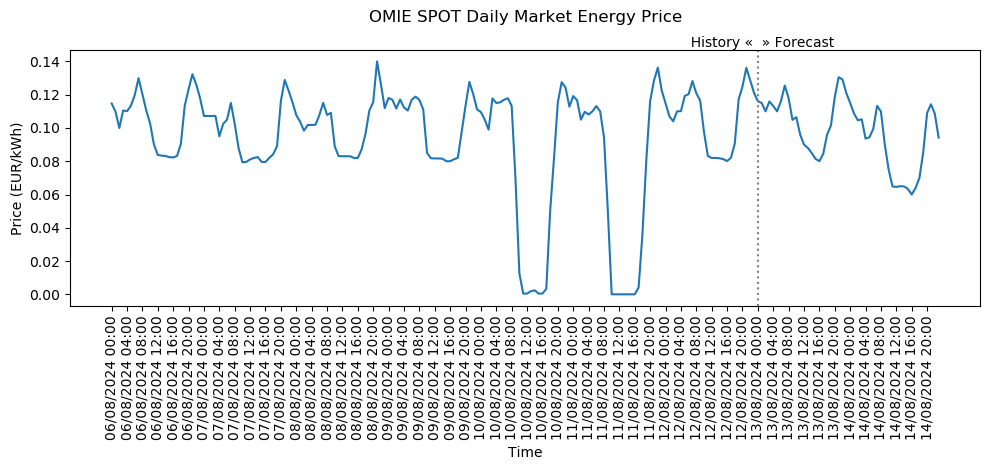

In [23]:
# Plot OMIE SPOT Daily Market price 
plt.figure().set_figwidth(10)
plt.plot(df_omie)
plt.title('OMIE SPOT Daily Market Energy Price', pad=20)
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Price (EUR/kWh)')
plt.xticks(range(0, len(df_omie), 4))
plt.tight_layout()
x_pos = len(df_omie)-48
plt.axvline(x=x_pos, color='gray', linestyle=':')
y_min, y_pos = plt.ylim()
plt.text(len(df_omie)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
plt.savefig(f"output_graphs/estimated_energy_omie_price.png")

***
# Estimation of grid energy sell price indexed to OMIE
### Method: considering seller profit margin, grid losses and access taxes
***

In [24]:
# Define typical seller parameters
K = 0.026 # Seller management system and profit margin
FP = 0.15 # Grid Loss Factor (aproximated value)
TAR = 0.03 # Grid Access Tax

# Function to calculate seller energy price
def calculate_seller_price(row):
    P_OMIE = row['pt_price']
    price = (P_OMIE + K) * (1+FP) + TAR
    return price

# Apply the function to the df_omie DataFrame
df_kwh_price = df_omie.apply(calculate_seller_price, axis=1)

# Print information
print(f"[{datetime.now()}] Grid energy sell price has been successfully estimated.")

# Print the Processed DataFrame (debug)
# print(df_kwh_price)

# Store the data
df_kwh_price.index.name = 'datetime'
df_kwh_price.name = 'grid_price'
df_kwh_price.to_csv((f"output_data/estimated_energy_grid_price.csv"))

[2024-08-13 19:52:24.814462] Grid energy sell price has been successfully estimated.


## Estimated Data Analysis

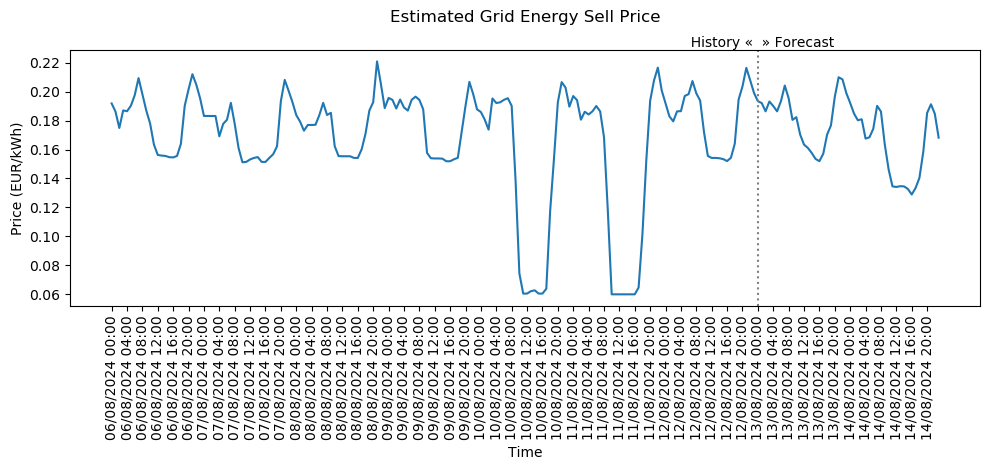

In [25]:
# Plot grid energy price 
plt.figure().set_figwidth(10)
plt.plot(df_kwh_price)
plt.title('Estimated Grid Energy Sell Price', pad=20)
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Price (EUR/kWh)')
plt.xticks(range(0, len(df_kwh_price), 4))
plt.tight_layout()
x_pos = len(df_kwh_price)-48
plt.axvline(x=x_pos, color='gray', linestyle=':')
y_min, y_pos = plt.ylim()
plt.text(len(df_kwh_price)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
plt.savefig(f"output_graphs/estimated_energy_grid_price.png")

# Print average (curiosity)
# print(sum(df_kwh_price)/len(df_kwh_price))